In [1]:
# Movie recommender
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/data

In [920]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

In [921]:
# Load the data
dataLoc = "~/Downloads/ratings.csv"
dataPD = pd.read_csv(dataLoc)

In [922]:
# What does the data look like
dataPD[0:10]

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148
6,1,2762,4.5,1425941300
7,1,2918,5.0,1425941593
8,1,2959,4.0,1425941601
9,1,4226,4.0,1425942228


Rows: 104097156
Distinct movies: 45115
Distinct Users: 270896
First timestamp: 1995-01-09 12:46:44
Last timestamp: 2017-08-04 08:57:50


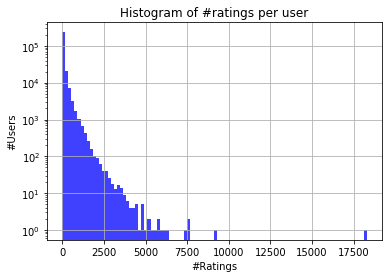

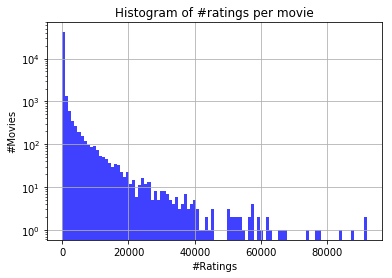

In [923]:
def showDataStats(inPD):
    # Get some numbers
    print("Rows: {0}".format(inPD.size))
    print("Distinct movies: {0}".format(inPD['movieId'].unique().size))
    print("Distinct Users: {0}".format(inPD['userId'].unique().size))
    print("First timestamp: {0}".format(datetime.datetime.fromtimestamp(inPD['timestamp'].min()).strftime('%Y-%m-%d %H:%M:%S')))
    print("Last timestamp: {0}".format(datetime.datetime.fromtimestamp(inPD['timestamp'].max()).strftime('%Y-%m-%d %H:%M:%S')))
    
    # Plot some histograms to get a feeling for the data
    numRatingsPerUserPD = inPD.groupby('userId')['movieId'].count()
    n, bins, patches = plt.hist(numRatingsPerUserPD.as_matrix(), 100, log=True, facecolor='blue', alpha=0.75)
    plt.xlabel('#Ratings')
    plt.ylabel('#Users')
    plt.title('Histogram of #ratings per user')
    plt.grid(True)
    plt.show()

    numRatingsPerMoviePD = inPD.groupby('movieId')['userId'].count()
    n, bins, patches = plt.hist(numRatingsPerMoviePD.as_matrix(), 100, log=True, facecolor='blue', alpha=0.75)
    plt.xlabel('#Ratings')
    plt.ylabel('#Movies')
    plt.title('Histogram of #ratings per movie')
    plt.grid(True)
    plt.show()
showDataStats(dataPD)

In [924]:
# For ease of use w/o overwriting dataPD
filteredDataPD = dataPD

In [925]:
# Filter out the users with little ratings (10th percentile)
# And filter out the users with many ratings (90th percentile)
numRatingsPerUserPD = filteredDataPD.groupby('userId')['movieId'].count()
filterOutUsersPD = numRatingsPerUserPD[(numRatingsPerUserPD <= np.percentile(numRatingsPerUserPD, 10))
                              | (numRatingsPerUserPD >= np.percentile(numRatingsPerUserPD, 90))]
filteredDataPD = filteredDataPD[~filteredDataPD['userId'].isin(filterOutUsersPD.index)]

# Show stats
# showDataStats(filteredDataPD)

In [926]:
# Filter out the bottom 95% of the movies
numRatingsPerMoviePD = filteredDataPD.groupby('movieId')['userId'].count()
filterOutMoviesPD = numRatingsPerMoviePD[(numRatingsPerMoviePD <= np.percentile(numRatingsPerMoviePD, 95))]
filteredDataPD = filteredDataPD[~filteredDataPD['movieId'].isin(filterOutMoviesPD.index)]

# Show stats
# showDataStats(filteredDataPD)

Rows: 3677760
Distinct movies: 1265
Distinct Users: 21611
First timestamp: 1995-01-09 12:46:49
Last timestamp: 2017-08-04 05:14:42


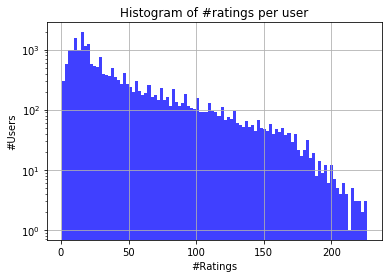

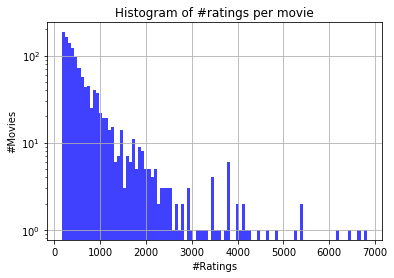

In [927]:
# Randomly filter out 90% of the users
distinctUsers = filteredDataPD['userId'].unique()
filterUsersPD = pd.DataFrame(distinctUsers, columns=['userId']).sample(frac=0.1)
filteredDataPD = filteredDataPD[filteredDataPD['userId'].isin(filterUsersPD['userId'])]

# Show stats
showDataStats(filteredDataPD)

In [928]:
# Convert pd dataframe to CF matrix (rating for each user, movie combination)
dataMat = filteredDataPD.pivot(index = 'userId', columns = 'movieId', values = 'rating')

In [929]:
# # Calculate rmse from prediction and actual values
# # Note: Only compares those elements which are not 0 in the ground truth
# def root_mean_squared_error(xPredMat, actual):
#     xPredMat = xPredMat[actual.nonzero()].flatten() 
#     actual = actual[actual.nonzero()].flatten()
#     return math.sqrt(mean_squared_error(xPredMat, actual))

In [930]:
trainPD, testPD = cv.train_test_split(dataMat, test_size=0.25)
trainUserRatingsMean = np.nanmean(np.nan_to_num(trainPD.as_matrix(),0), axis = 1)
trainMatDemeaned = trainPD.as_matrix() - trainUserRatingsMean.reshape(-1, 1)
testUserRatingsMean = np.nanmean(np.nan_to_num(testPD.as_matrix(),0), axis = 1)
testMatDemeaned = testPD.as_matrix() - testUserRatingsMean.reshape(-1, 1)

In [931]:
u, sigma, vt = svds(trainMatDemeaned, k=20)
sigma = np.diag(sigma)
predictedRatings = np.dot(np.dot(u, sigma), vt) + trainUserRatingsMean.reshape(-1, 1)
predictionsPD = pd.DataFrame(predictedRatings, columns = trainPD.columns)

In [ ]:
# Test by leaving out known values. So it's actually doable in the filtering(?)

In [618]:
# Get ID with movies
# Read necessary tables
moviesLoc = "~/Downloads/movies_metadata.csv"
moviesPD = pd.read_csv(moviesLoc)
moviesIdsLoc = "~/Downloads/links.csv"
moviesIdsLocPD = pd.read_csv(moviesIdsLoc)

# Clean required data
moviesPD['imdb_id'] = moviesPD['imdb_id'].apply(lambda x: str(x).replace('tt','0').strip('0')).replace('nan',0).replace('',0).fillna(0).astype(int)
moviesIdsLocPD['tmdbId'] = moviesIdsLocPD['tmdbId'].fillna(0).astype(int)
moviesIdsLocPD['imdbId'] = moviesIdsLocPD['imdbId'].fillna(0).astype(int)

# Join tables, get necessary columns
moviesIdsJoinedPD = moviesIdsLocPD.merge(moviesPD, left_on='imdbId', right_on='imdb_id', how='inner')
moviesIdPD = pd.concat([moviesIdsJoinedPD['movieId'],moviesIdsJoinedPD['tmdbId'],moviesIdsJoinedPD['imdbId'],moviesIdsJoinedPD['original_title']], axis=1).rename(columns={"movieId": "id"})

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
